# ARIMA Modeling

In this section we're going to begin fitting our data to ARIMA models and make predictions about the increase of COVID-19 cases in America.  

Due to time constraints, we will only be modeling the states with the top 5 highest number of cases.  If you remember from notebook 2, those states are California, Florida, Georgia, New York, and Texas.

Time to get started!

# Importing Data

In [88]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [89]:
df = pd.read_csv('national_positive_increase.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           256 non-null    object
 1   AK_positiveIncrease  256 non-null    int64 
 2   AL_positiveIncrease  256 non-null    int64 
 3   AR_positiveIncrease  256 non-null    int64 
 4   AS_positiveIncrease  256 non-null    int64 
 5   AZ_positiveIncrease  256 non-null    int64 
 6   CA_positiveIncrease  256 non-null    int64 
 7   CO_positiveIncrease  256 non-null    int64 
 8   CT_positiveIncrease  256 non-null    int64 
 9   DC_positiveIncrease  256 non-null    int64 
 10  DE_positiveIncrease  256 non-null    int64 
 11  FL_positiveIncrease  256 non-null    int64 
 12  GA_positiveIncrease  256 non-null    int64 
 13  GU_positiveIncrease  256 non-null    int64 
 14  HI_positiveIncrease  256 non-null    int64 
 15  IA_positiveIncrease  256 non-null    int64 
 16  ID_posit

In [90]:
# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

df.head()

,AK_positiveIncrease,AL_positiveIncrease,AR_positiveIncrease,AS_positiveIncrease,AZ_positiveIncrease,CA_positiveIncrease,CO_positiveIncrease,CT_positiveIncrease,DC_positiveIncrease,DE_positiveIncrease,...,TN_positiveIncrease,TX_positiveIncrease,UT_positiveIncrease,VA_positiveIncrease,VI_positiveIncrease,VT_positiveIncrease,WA_positiveIncrease,WI_positiveIncrease,WV_positiveIncrease,WY_positiveIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Alright, now that the dataframe is loaded up, let's subset the data of our top 5 states into their own dataframes.

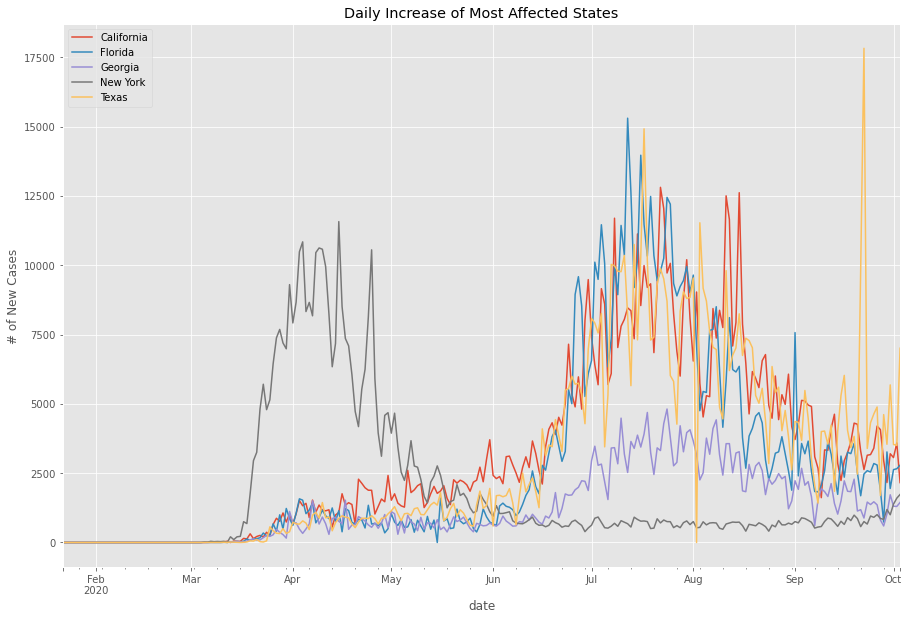

In [91]:
# California
ca = df['CA_positiveIncrease']
ca.plot(figsize=(15, 10), label='California')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

# Georgia
ga = df['GA_positiveIncrease']
ga.plot(figsize=(15, 10), label='Georgia')

# New York
ny = df['NY_positiveIncrease']
ny.plot(figsize=(15, 10), label='New York')

# Texas
tx = df['TX_positiveIncrease']
tx.plot(figsize=(15, 10), label='Texas')

plt.ylabel('# of New Cases')
plt.title('Daily Increase of Most Affected States')
plt.legend()
plt.show();

Awesome! We remember this messy plot from notebook 2!  Now, since we only have data between the end of January and the beginning of October, we shouldn't need to resample.  256 values per state is low enough, all things considered. If we resampled by the week, that would leave us with ~ 36 weeks, which might not be a enough data to get accurate data.  

# Auto-Correlation and Decomposition

While the very fact that we're dealing with a disease, and that people's exposure risk and immune systems are all different, I think it's safe to say that there is no seasonality (yet, and hopefully it stays that way).  Let's just check just to be sure though.

In [4]:
def lag(df, n):
    '''
    Input: Dataframe and 'n' number of periods(int)
    Output: Dataframe that contains concatenation of the lag shifted data and 
    original dataframe.
    '''
    # Shift data by 'n' number of periods
    shift = df.shift(periods=n)
    
    # Concat new data with original dataframe
    concat = pd.concat([shift, df], axis=1)
    
    return concat

## Calculating Q

In [5]:
# California Auto-Correlation
ca_lag_1 = lag(ca, 1)

# Check correlation after day lag
ca_lag_1.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.925779
CA_positiveIncrease,0.925779,1.000000


Ok, as to be expected, it's very correlated after a single lag (equal to 1 day). Let's take a look at correlation after 7-days. 

In [6]:
ca_lag_7 = lag(ca, 7)
ca_lag_7.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.878137
CA_positiveIncrease,0.878137,1.000000


That's actually a pretty strong correlation after a week.  Because COVID-19 has an incubation period of up to 14 days, let's try 14 next.

In [7]:
ca_lag_14 = lag(ca, 14)

ca_lag_14.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.816383
CA_positiveIncrease,0.816383,1.000000


This is very interesting. There is still very high correlation.  Let's see how long this goes on for.

<Figure size 1440x1008 with 0 Axes>

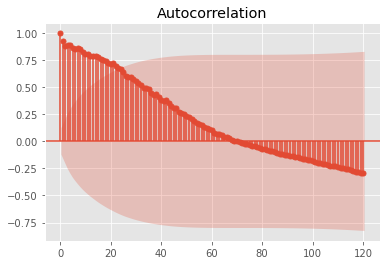

In [8]:
from statsmodels.graphics.tsaplots import plot_acf


plt.figure(figsize=(20,14))
plot_acf(ca, lags = 120);

According to the ACF plot, this correlation remains strong even when you count back 22 days!  This means that our q-value could potentially be up to 22, but let's check out the PACF plot and see which lags are significant. Also, notice how the ACF seems to tail off instead of cutting off. 

## Calculating P

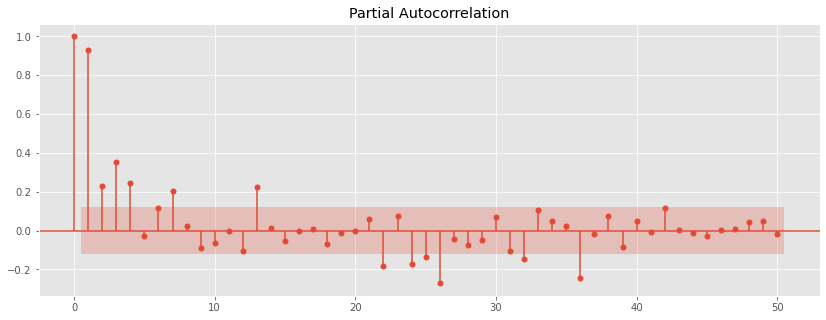

In [92]:
from statsmodels.graphics.tsaplots import plot_pacf

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5


plot_pacf(ca, lags=50);

The PACF plot tells us that the last 5 lags are the most significant. The plot also shows sharp drop in significance, so we're probably looking at an AR model.  So it would seem that our p-value is up to 5.  

Now let's find out the seasonality.

## Seasonality

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(series):
    """
    Input a series
    
    Decompose a time series and plot it
    
    Outputs: 
        Decomposition plot
    """
    result = seasonal_decompose(series)
    result.plot()
    plt.show();

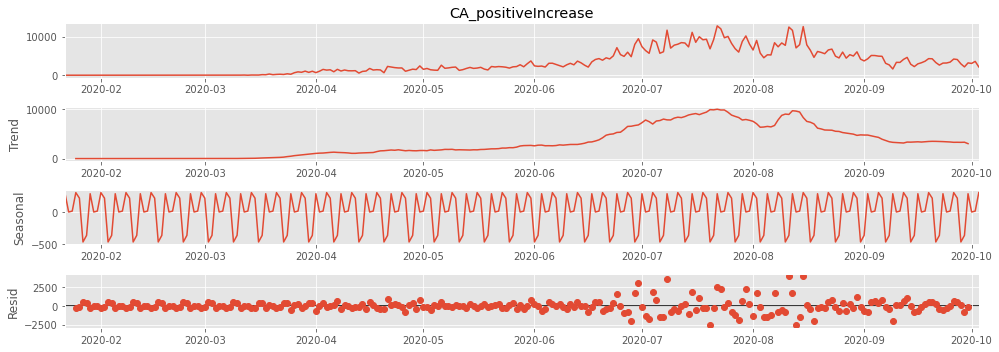

In [94]:
decompose_time_series(ca)

It appears that there are about 4 or 5 seasonal periods per month.  This seems to correspond to the number of weeks in a month.  So our s-value is 7 days.

## Bringing it all together

Now that we have our ranges for P, D, Q, and S, we can create a grid search to find the optimal parameters for our SARIMA model.

In [95]:
def pdq_parameters(timeseries, p_range = 2, d_range = 2, q_range = 2, s = 0):
    '''
    Input: Time Series Dataframe, range values for ARIMA(p, d, q), and an 
    optional value for seasonality (s).
    
    The function will generate values between within the given range (default 
    between 0 and 1) for p, d, and q, compile them into lists and run them 
    through a model fit to the given time series.
    
    It will return a list of the parameters and their associate AIC scores.  
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(p_range)
    d = range(d_range)
    q = range(q_range)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=combination,
                                                seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    return results

In [18]:
ca_parameters = pdq_parameters(ca, p_range=6, d_range=2, q_range=6, s=7)

In [20]:
ca_parameters

[[(0, 0, 0), (0, 0, 0, 7), 5032.87302448085],
 [(0, 0, 0), (0, 0, 1, 7), 4806.360598792187],
 [(0, 0, 0), (0, 0, 2, 7), 4714.573068839068],
 [(0, 0, 0), (0, 0, 3, 7), 4628.9124779347185],
 [(0, 0, 0), (0, 0, 4, 7), 4576.564932519232],
 [(0, 0, 0), (0, 0, 5, 7), 4566.918141519094],
 [(0, 0, 0), (0, 1, 0, 7), 4369.734657407144],
 [(0, 0, 0), (0, 1, 1, 7), 4356.089371856607],
 [(0, 0, 0), (0, 1, 2, 7), 4357.009848232952],
 [(0, 0, 0), (0, 1, 3, 7), 4344.886149505839],
 [(0, 0, 0), (0, 1, 4, 7), 4346.822434615648],
 [(0, 0, 0), (0, 1, 5, 7), 4347.094850998274],
 [(0, 0, 0), (1, 0, 0, 7), 4495.910778096732],
 [(0, 0, 0), (1, 0, 1, 7), 4485.186891056126],
 [(0, 0, 0), (1, 0, 2, 7), 4483.856885273894],
 [(0, 0, 0), (1, 0, 3, 7), 4472.739407702672],
 [(0, 0, 0), (1, 0, 4, 7), 4474.713225307114],
 [(0, 0, 0), (1, 0, 5, 7), 4473.298453085336],
 [(0, 0, 0), (1, 1, 0, 7), 4355.757490975116],
 [(0, 0, 0), (1, 1, 1, 7), 4357.381652968344],
 [(0, 0, 0), (1, 1, 2, 7), 4350.946467539554],
 [(0, 0, 0), 

Now let's find out what the best parameters are.

In [12]:
def best_params(ts_param_list):
    '''
    Input: list of pdq parameters
    
    Function appends all AIC scores to a list, finds the minimum value, and 
    returns the corresponding parameters
    
    Output: Parameters for SARIMA Modeling
    '''

    # List for storing AIC values
    aic = []
    
    # Store AIC values
    for i in range(len(ts_param_list)):
        aic.append(ts_param_list[i][2])
    
    # List for storing best parameters. Using List in case there are multiple 
    # parameters that create the same AIC 
    best = []
    
    # Find parameters associated with lowest AIC
    for i in range(len(ts_param_list)):
        if ts_param_list[i][2] == min(aic):
            best.append(ts_param_list[i])

    return best

In [25]:
best_params(ca_parameters)

[[(3, 1, 0), (0, 1, 1, 7), 4170.587071953259]]

So after 9 and a half hours we found our best parameters.  We'll have to do this four more times, meaning that we could potentially end up spending close to 48 hours just computing parameters.  Let's enlist the help of Auto ARIMA and compare AIC scores.  

The Auto-ARIMA function is a python derivative of a function used in the R programming language which finds the best seasonal and non-seasonal parameters and in a tiny fraction of the time.

In [71]:
import pmdarima as pm

ca_results = pm.auto_arima(ca,information_criterion='aic', m=8 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ca_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 8); AIC=4289.325, BIC=4310.572, Fit time=0.276 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 8); AIC=4346.882, BIC=4353.964, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 8); AIC=4326.294, BIC=4340.460, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 8); AIC=4294.715, BIC=4308.880, Fit time=0.109 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 8); AIC=4288.077, BIC=4305.783, Fit time=0.553 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 8); AIC=4293.169, BIC=4307.334, Fit time=0.232 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 2, 8); AIC=4289.397, BIC=4310.644, Fit time=0.612 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 8); AIC=4291.316, BIC=4316.105, Fit time=0.564 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 8); AIC=4285.045, BIC=4306.293, Fit time=0.161 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 1, 8), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Ok, so the AIC is a little bit higher, but not by much, and we completed this in 15 seconds! For California, we'll use the parameters that we painstakingly waited for, but our other 4 states, we'll use Auto-ARIMA.  

Let's go ahead and split our data now.

In [16]:
def train_test(df):
    '''
    Input a dataframe.
    
    Function resets the index, and calculates the proportion of data to 
    allocate to the respective datasets.  It then creates the datasets by 
    indexing the values.  Finally, both datasets have the index set back to 
    'date'.
    
    Output: Train and Test sets for Time Series Analysis
    '''
    # Reset Index
    temp = df.reset_index()
    
    # Training set test size
    train_size = int(round(len(df.index) * 0.80, 0))
    
    # Set training data
    train = temp.iloc[:train_size]
    
    # Set test data
    test = temp.iloc[train_size:]
    
    # Set index back to 'date'
    train = train.set_index('date')
    test = test.set_index('date')
    
    # Set Frequency to Days
    train = train.asfreq('D')
    test = test.asfreq('D')
    return train, test

In [18]:
df_train, df_test = train_test(df)

In [19]:
len(df_train.index)

205

Perfect! Dataframe is split now, so lets make training and test sets for California.

In [20]:
ca_train = df_train[['CA_positiveIncrease']]

ca_test = df_test[['CA_positiveIncrease']]

ca_train


,CA_positiveIncrease
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-08-09,8373
2020-08-10,7751
2020-08-11,12500


## Fitting Model

In [55]:
def fit_model(series_train, series_test, pdq=(1,0,1),pdqs=(0,0,0,1)):
    model = sm.tsa.statespace.SARIMAX(series_train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return series_train, series_test, results

                                      SARIMAX Results                                      
Dep. Variable:                 CA_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1648.307
Date:                             Sun, 11 Oct 2020   AIC                           3306.614
Time:                                     14:03:26   BIC                           3323.030
Sample:                                 01-22-2020   HQIC                          3313.260
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4290      0.047     -9.152      0.000      -0.521      -0.337
ar.L2         -0.4229      

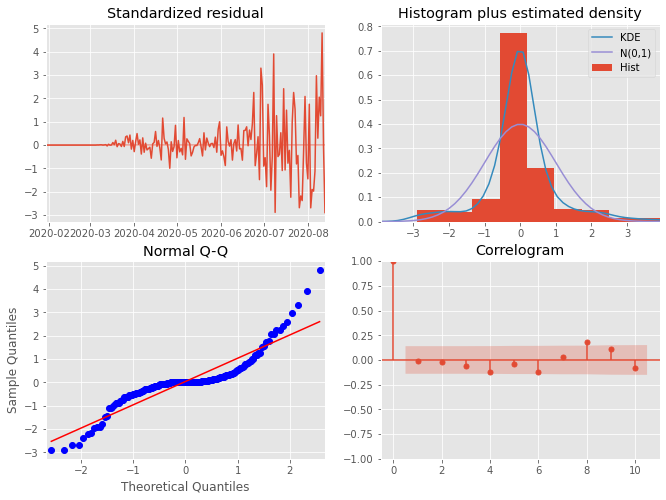

In [75]:
pdq = (3, 1, 0)
pdqs = (0, 1, 1, 7)
train, test, results = fit_model(ca_train, ca_test, pdq=pdq, pdqs=pdqs)

In [78]:
from sklearn.metrics import mean_squared_error as MSE

def test_RMSE(series_train, series_test, pdq, pdqs, display=True):
    X_train = series_train.values
    X_test = series_test.values
    train, test = X_train, X_test
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq,seasonal_order=pdqs)
        fit_model = model.fit(disp=0)
        output = fit_model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-51:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-56)
    rmse = np.sqrt(MSE(train[-56:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

SARIMA model RMSE on test data: 1204.54756


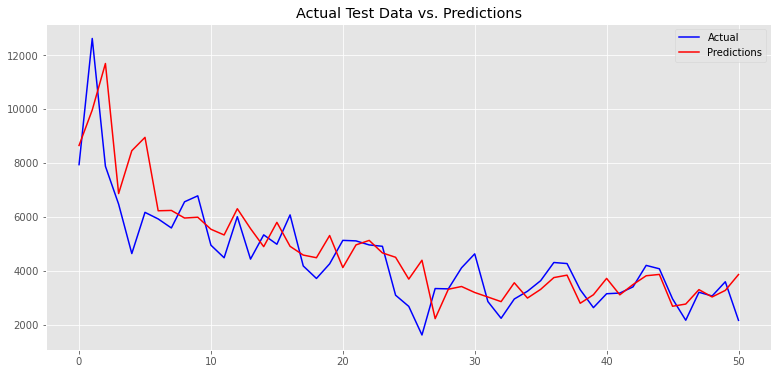

In [79]:
test_RMSE(ca_train, ca_test, pdq, pdqs)

SARIMA model RMSE on train data: 1838.36525


<Figure size 936x432 with 0 Axes>

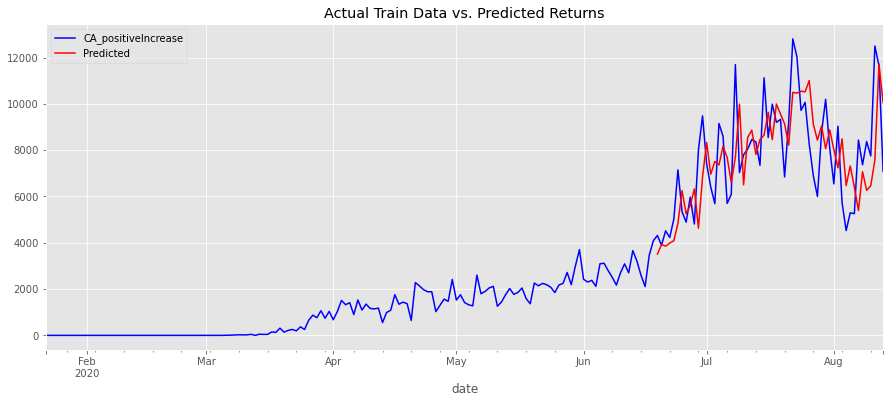

In [80]:
train_RMSE(ca_train, results)

In [45]:
ca_model1 = sm.tsa.statespace.SARIMAX(ca_train, order=(3, 1, 0), 
                                  seasonal_order=(0, 1, 1, 7), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

# Fit the model and print results
output1 = ca_model1.fit()

print(output1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4307      0.049     -8.844      0.000      -0.526      -0.335
ar.L2         -0.4251      0.044     -9.680      0.000      -0.511      -0.339
ar.L3         -0.2735      0.061     -4.463      0.000      -0.394      -0.153
ma.S.L7       -0.8697      0.032    -26.901      0.000      -0.933      -0.806
sigma2      1.091e+06   6.27e+04     17.408      0.000    9.68e+05    1.21e+06


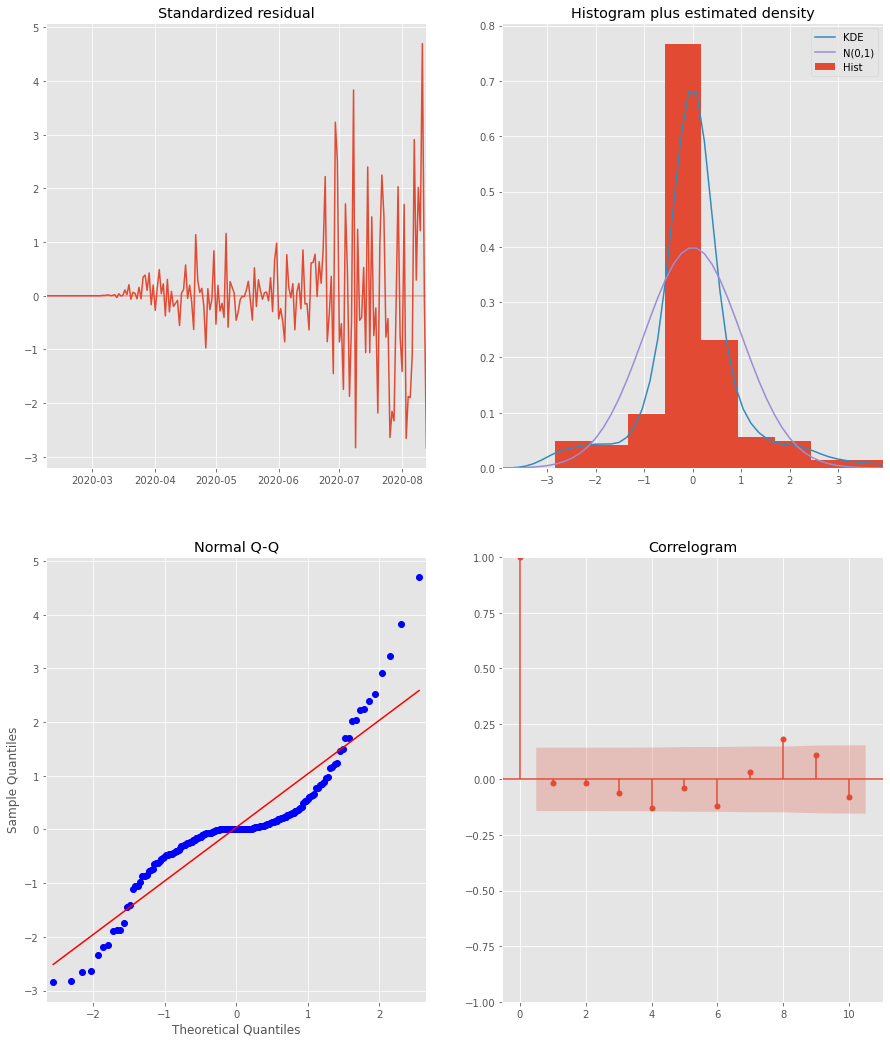

In [46]:
# Call plot_diagnostics() on the results calculated above 
output1.plot_diagnostics(figsize=(15, 18))
plt.show()

### Training Predictions

In [43]:
pred1 = output1.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_conf1 = pred1.conf_int()

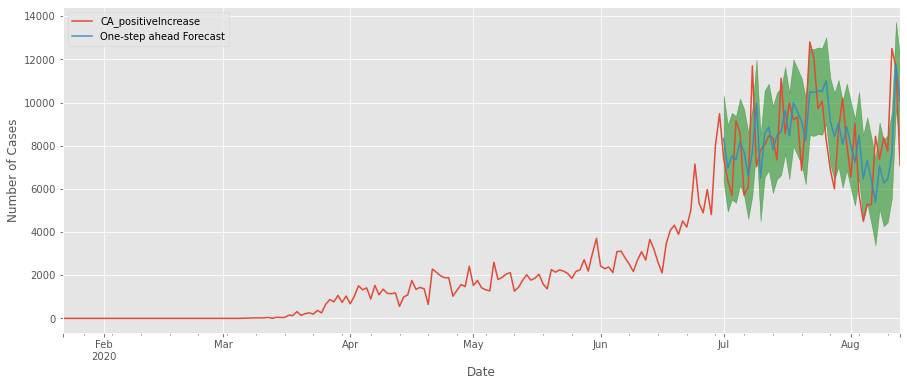

In [44]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ca_train['2020-01-22':].plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf1.index,
                pred_conf1.iloc[:, 0],
                pred_conf1.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
plt.legend()

plt.show()

In [53]:
ca_model = sm.tsa.statespace.SARIMAX(ca_train, order=(1, 1, 1), 
                                  seasonal_order=(1, 1, 1, 12), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

# Fit the model and print results
output = ca_model.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2188      0.090      2.445      0.015       0.043       0.394
ma.L1         -0.7627      0.060    -12.792      0.000      -0.880      -0.646
ar.S.L12      -0.1933      0.071     -2.704      0.007      -0.333      -0.053
ma.S.L12      -1.0187      0.325     -3.138      0.002      -1.655      -0.382
sigma2      1.148e+06   4.21e+05      2.725      0.006    3.22e+05    1.97e+06


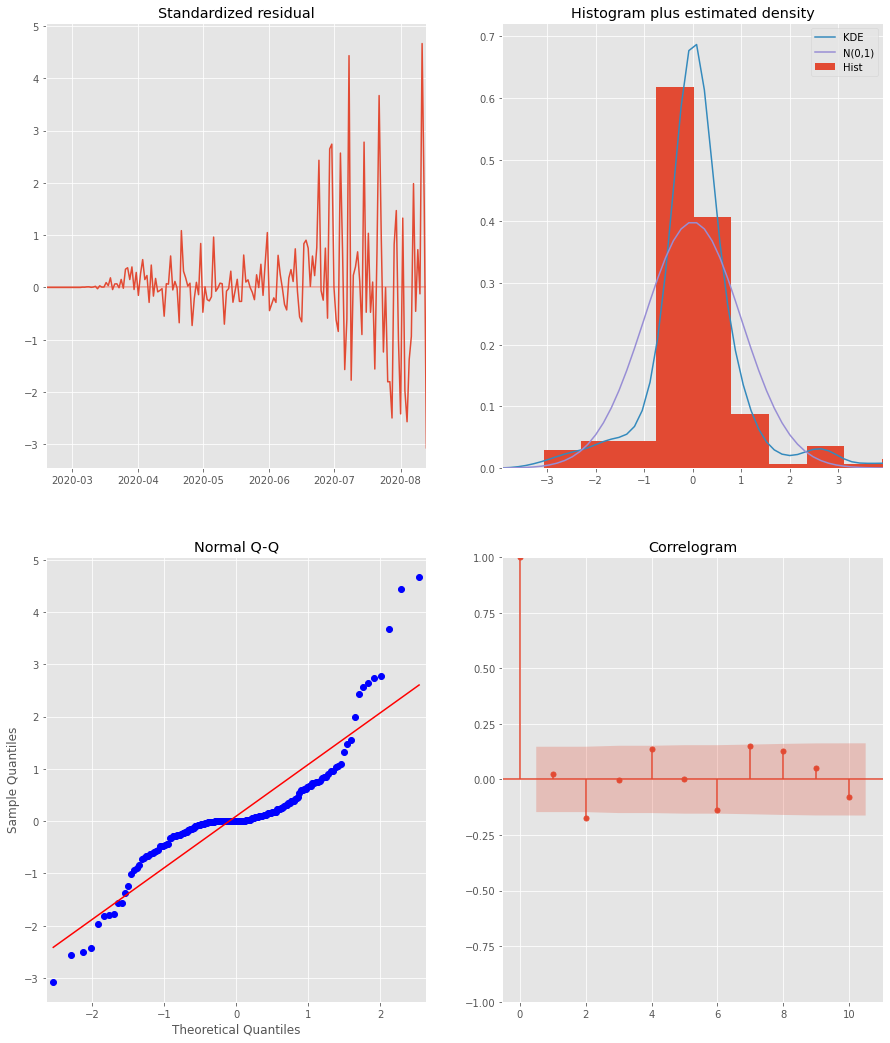

In [54]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [62]:
pred = output.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_conf = pred.conf_int()

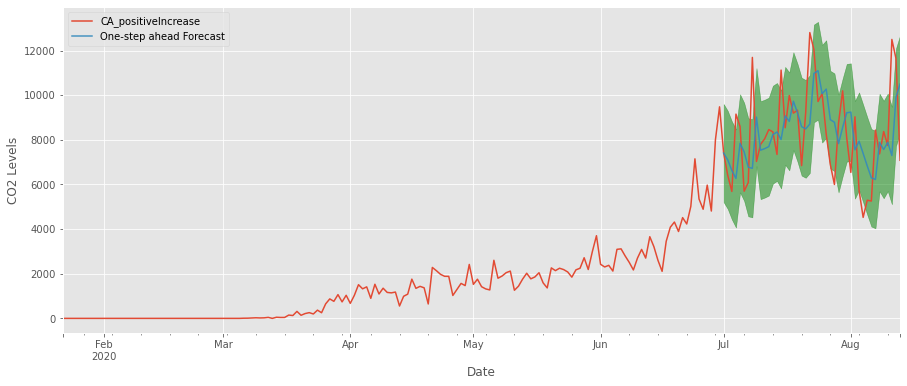

In [63]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ca_train['2020-01-22':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

### Test Predictions

In [47]:
# Finding start date for Test df
ca_test.head()

,CA_positiveIncrease
date,
2020-08-14,7934
2020-08-15,12614
2020-08-16,7873
2020-08-17,6469
2020-08-18,4636


In [48]:
ca_model2 = sm.tsa.statespace.SARIMAX(ca_test, order=(3, 1, 0), 
                                  seasonal_order=(0, 1, 1, 7), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

# Fit the model and print results
output2 = ca_model2.fit()

print(output2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6239      0.235     -2.652      0.008      -1.085      -0.163
ar.L2         -0.2912      0.289     -1.009      0.313      -0.857       0.274
ar.L3         -0.2779      0.187     -1.484      0.138      -0.645       0.089
ma.S.L7       -0.4328      0.171     -2.534      0.011      -0.768      -0.098
sigma2      4.957e+05   1.01e+05      4.889      0.000    2.97e+05    6.94e+05


In [ ]:
# Call plot_diagnostics() on the results calculated above 
output2.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred2 = output1.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_conf1 = pred2.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ca_train['2020-01-22':].plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf1.index,
                pred_conf1.iloc[:, 0],
                pred_conf1.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
plt.legend()

plt.show()

# Florida

In [81]:
fl.head()

0    0
1    0
2    0
3    0
4    0
Name: FL_positiveIncrease, dtype: int64

In [82]:
# Creating training and test sets
fl_train = df_train[['FL_positiveIncrease']]

fl_test = df_test[['FL_positiveIncrease']]

## Florida ACF and PACF Plots

In [85]:
def acf_pacf(series, alags=120, plags=22):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    #Make ACF plot
    plot_acf(series,lags=alags, zero=False,ax=ax1)
    #Make PACF plot
    plot_pacf(series,lags=plags, ax=ax2)
    plt.show()

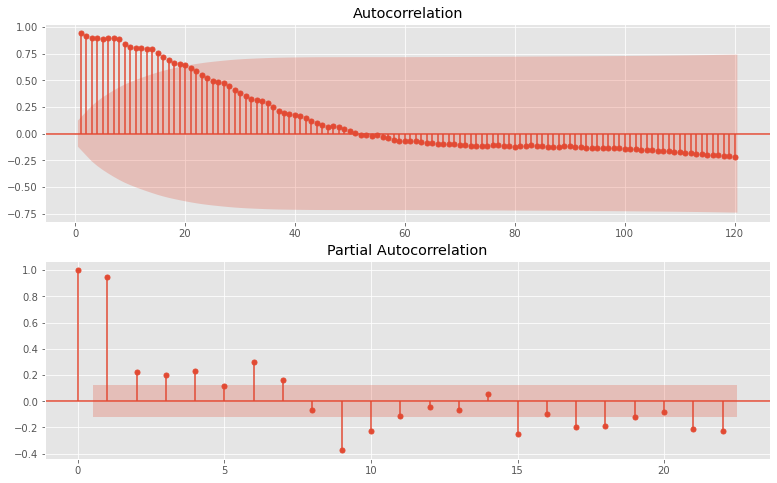

In [86]:
acf_pacf(fl)

In [87]:
decompose_time_series(fl)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [ ]:
fl_results = pm.auto_arima(fl,information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ca_results